In [5]:
#7 - Data Preprocessing
# =====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("dateset for handwriting.csv")
print("Dataset loaded successfully.")
print("Shape:", df.shape)
print("First 5 rows:\n", df.head())

# Separate features and labels (label is the last column)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalize pixel values to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape features for CNN input: (num_samples, 8, 8, 1)
X_scaled = X_scaled.reshape(-1, 8, 8, 1)

# One-hot encode labels
y_encoded = to_categorical(y, num_classes=10)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Preprocessing complete.")

Dataset loaded successfully.
Shape: (5620, 65)
First 5 rows:
    0  1   2   3   4   5  6  7  8  9  ...  55  56  57  58  59  60  61  62  63  \
0  0  1   6  15  12   1  0  0  0  7  ...   0   0   0   6  14   7   1   0   0   
1  0  0  10  16   6   0  0  0  0  7  ...   0   0   0  10  16  15   3   0   0   
2  0  0   8  15  16  13  0  0  0  1  ...   0   0   0   9  14   0   0   0   0   
3  0  0   0   3  11  16  0  0  0  0  ...   0   0   0   0   1  15   2   0   0   
4  0  0   5  14   4   0  0  0  0  0  ...   0   0   0   4  12  14   7   0   0   

   64  
0   0  
1   0  
2   7  
3   4  
4   6  

[5 rows x 65 columns]
X_train shape: (4496, 8, 8, 1)
y_train shape: (4496, 10)
Preprocessing complete.


<ipython-input-6-7a7e74b50287>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels.index, y=labels.values, palette="viridis")


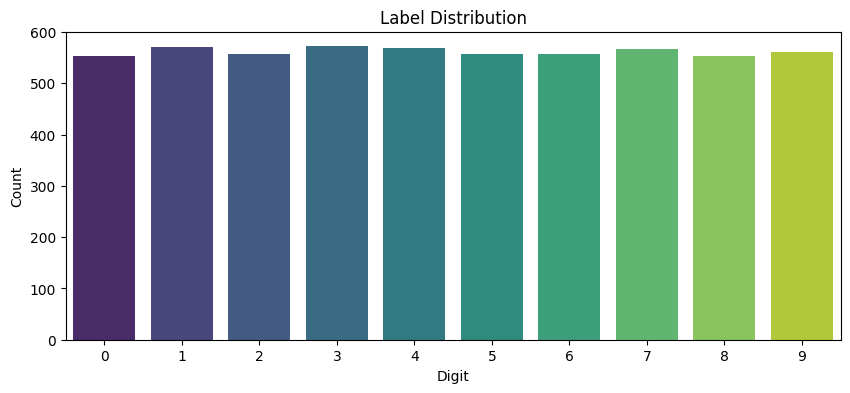

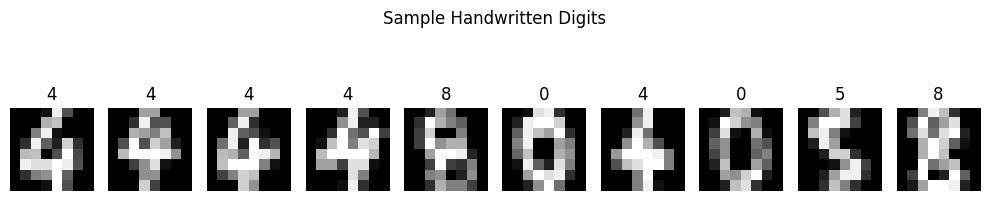

In [6]:
#8 - Exploratory Data Analysis (EDA)
# ==================================
import matplotlib.pyplot as plt
import seaborn as sns

# Plot label distribution
labels = df.iloc[:, -1].value_counts().sort_index()
plt.figure(figsize=(10, 4))
sns.barplot(x=labels.index, y=labels.values, palette="viridis")
plt.title("Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

# Show sample images
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i].reshape(8, 8), cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample Handwritten Digits", y=1.2)
plt.show()

In [7]:
#9 - Feature Engineering
# ======================
# Basic feature engineering using mean and std as additional channels

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

train_mean = np.mean(X_train_flat, axis=1).reshape(-1, 1)
train_std = np.std(X_train_flat, axis=1).reshape(-1, 1)
test_mean = np.mean(X_test_flat, axis=1).reshape(-1, 1)
test_std = np.std(X_test_flat, axis=1).reshape(-1, 1)

# Add as extra channels (broadcast to shape)
X_train_eng = np.concatenate([
    X_train,
    train_mean[:, None, None, :].repeat(8, axis=1).repeat(8, axis=2),
    train_std[:, None, None, :].repeat(8, axis=1).repeat(8, axis=2)
], axis=-1)

X_test_eng = np.concatenate([
    X_test,
    test_mean[:, None, None, :].repeat(8, axis=1).repeat(8, axis=2),
    test_std[:, None, None, :].repeat(8, axis=1).repeat(8, axis=2)
], axis=-1)

print("After Feature Engineering:")
print("X_train_eng shape:", X_train_eng.shape)
print("X_test_eng shape:", X_test_eng.shape)

After Feature Engineering:
X_train_eng shape: (4496, 8, 8, 3)
X_test_eng shape: (1124, 8, 8, 3)


In [8]:
#10 - Model Building
# ==================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("CNN Model Summary:")
model.summary()

# Train the model
history = model.fit(X_train_eng, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1,
                    verbose=1)

CNN Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,578 (209.29 KB)

 Trainable params: 53,578 (209.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1633 - loss: 2.2598 - val_accuracy: 0.7911 - val_loss: 1.4844
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5862 - loss: 1.3530 - val_accuracy: 0.9000 - val_loss: 0.4014
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8122 - loss: 0.6071 - val_accuracy: 0.9356 - val_loss: 0.2140
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8768 - loss: 0.4085 - val_accuracy: 0.9689 - val_loss: 0.1226
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9072 - loss: 0.3025 - val_accuracy: 0.9822 - val_loss: 0.0955
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9211 - loss: 0.2531 - val_accuracy: 0.9800 - val_loss: 0.0749
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9343 - loss: 0.2241 - val_accuracy: 0.9844 - val_loss: 0.0554
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9463 - loss: 0.1584 - val_accuracy: 0.9867 - v


Test Accuracy: 0.9867 | Test Loss: 0.0447


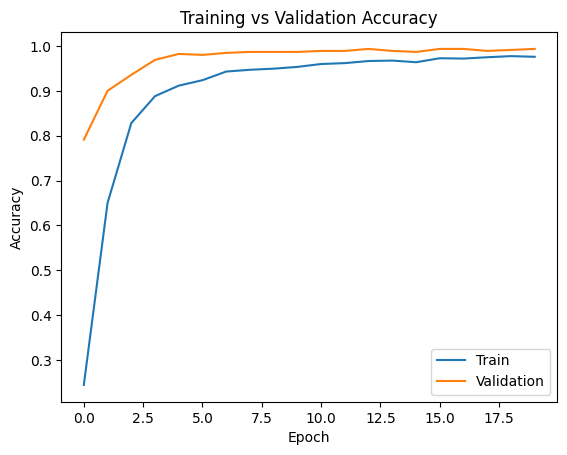

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


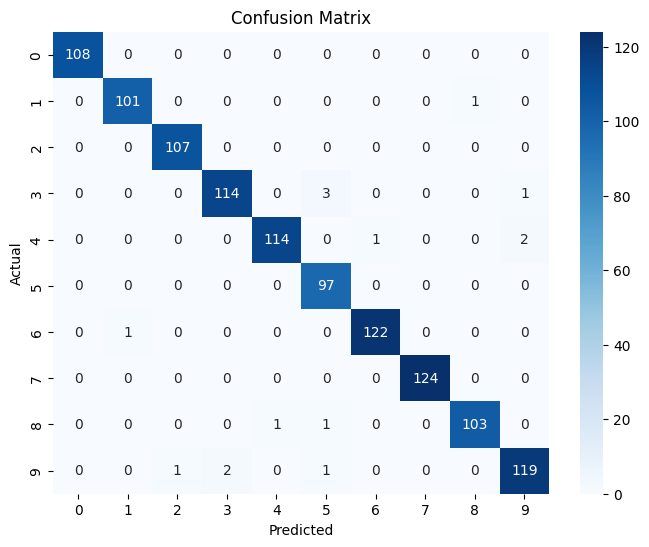

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       0.99      0.99      0.99       102
           2       0.99      1.00      1.00       107
           3       0.98      0.97      0.97       118
           4       0.99      0.97      0.98       117
           5       0.95      1.00      0.97        97
           6       0.99      0.99      0.99       123
           7       1.00      1.00      1.00       124
           8       0.99      0.98      0.99       105
           9       0.98      0.97      0.97       123

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model and label map saved and downloaded successfully.


In [9]:
#11 - Model Evaluation & Save Files
# =================================
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_eng, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Predictions
y_pred = np.argmax(model.predict(X_test_eng), axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Save model and label encoder
model.save("handwriting_cnn_model.h5")

# Create a dummy label map
import pickle
label_map = {i: str(i) for i in range(10)}
with open("label_map.pkl", "wb") as f:
    pickle.dump(label_map, f)

# Download files
from google.colab import files
files.download("handwriting_cnn_model.h5")
files.download("label_map.pkl")

print("Model and label map saved and downloaded successfully.")